<a href="https://colab.research.google.com/github/matiasvallejosdev/ar-dl-color-mapping/blob/main/Project.DeepLearning/cm_imageclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [173]:
!pip install --upgrade pillow

You should consider upgrading via the 'c:\python3\python.exe -m pip install --upgrade pip' command.


In [1]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras as tk
import tensorflow.keras.preprocessing.image as tfi
import numpy as np
import pandas as pd

import pathlib
import imageio
import random

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

tf.__version__

'2.7.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [11]:
DATA_DIR = "../dogs-vs-cats" 
os.chdir(DATA_DIR)
os.listdir()

['sampleSubmission.csv', 'test', 'train']

## Load data

In [12]:
EPOCHS = 5
BATCH_SIZE = 12

IMAGE_WIDHT = 128
IMAGE_HEIGHT = 128
IMAGE_SHAPE = (IMAGE_WIDHT, IMAGE_HEIGHT) # (height, width) in no. of pixels
IMAGE_CHANNELS = 3

print(DATA_DIR)

../dogs-vs-cats


## Prepare data to train

In [13]:
def plotImages(images_arr, size):
    fig, axes = plt.subplots(1, size, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [14]:
train_dir = DATA_DIR + "/train/"
test_dir = DATA_DIR + "/test/"

print(train_dir)
print(test_dir)

../dogs-vs-cats/train/
../dogs-vs-cats/test/


In [15]:
filenames = os.listdir(train_dir)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [16]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [17]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


<AxesSubplot:>

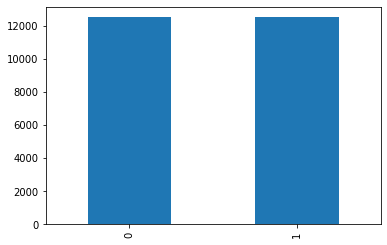

In [18]:
df['category'].value_counts().plot.bar()

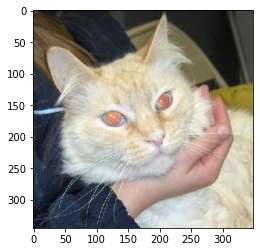

In [19]:
sample = random.choice(filenames)
image = tf.keras.preprocessing.image.load_img(train_dir + sample)
plt.imshow(image)

In [20]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [21]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [22]:
print(train_df["category"].value_counts())

dog    10015
cat     9985
Name: category, dtype: int64


In [23]:
print(validate_df["category"].value_counts())

cat    2515
dog    2485
Name: category, dtype: int64


In [24]:
# Define generators
train_datagen = tfi.ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest")

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    train_dir,
    color_mode="rgb",
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SHAPE,
    class_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 20000 validated image filenames belonging to 2 classes.


In [25]:
validation_datagen = tfi.ImageDataGenerator(rescale=1 / 255.0)
valid_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    train_dir, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


In [26]:
class_names = train_generator.class_indices
print("Name classes: {}".format(class_names))

Name classes: {'cat': 0, 'dog': 1}


In [27]:
imgs, labels = next(train_generator)

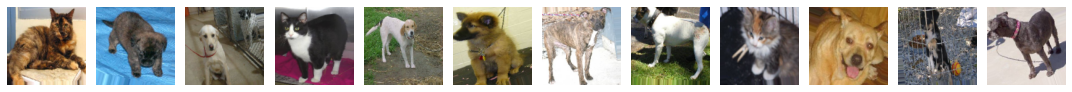

In [28]:
plotImages(imgs, BATCH_SIZE)

## Define model

In [ ]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [29]:
model = tf.keras.Sequential([
            tfl.Conv2D(32, 3, padding='same', activation='relu',input_shape=(128,128,3)),
            tfl.BatchNormalization(),
            tfl.MaxPooling2D(),
            tfl.Dropout(0.25),

            tfl.Conv2D(64, (3,3), padding='same', activation='relu'),
            tfl.BatchNormalization(),
            tfl.MaxPooling2D(),
            tfl.Dropout(0.25),

            tfl.Conv2D(128, (3,3), padding='same', activation='relu'),
            tfl.BatchNormalization(),
            tfl.MaxPooling2D(),
            tfl.Dropout(0.25),

            tfl.Flatten(),
            tfl.Dense(512, activation='relu'),
            tfl.BatchNormalization(),
            tfl.Dropout(0.5),
            tfl.Dense(2, activation='softmax')
])

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       2

## Train model

In [31]:
history = model.fit_generator(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=EPOCHS)

<ipython-input-31-ca308f1409ae>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/5
1666/1666 [==============================] - 541s 324ms/step - loss: 0.7464 - accuracy: 0.6303 - val_loss: 0.5302 - val_accuracy: 0.7270
Epoch 2/5
1666/1666 [==============================] - 516s 310ms/step - loss: 0.5508 - accuracy: 0.7292 - val_loss: 0.4899 - val_accuracy: 0.7550
Epoch 3/5
1666/1666 [==============================] - 504s 302ms/step - loss: 0.4979 - accuracy: 0.7630 - val_loss: 0.4889 - val_accuracy: 0.7658
Epoch 4/5
1666/1666 [==============================] - 526s 316ms/step - loss: 0.4623 - accuracy: 0.7860 - val_loss: 0.4219 - val_accuracy: 0.8083
Epoch 5/5
1666/1666 [==============================] - 567s 340ms/step - loss: 0.4363 - accuracy: 0.8049 - val_loss: 0.3682 - val_accuracy: 0.8347


## Validate model

In [32]:
model.save_weights("model.h5")

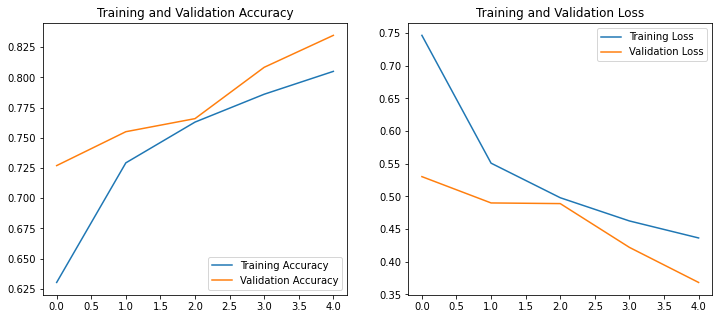

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Test model

### Prepare test data

In [134]:
test_filenames = os.listdir(test_dir)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [135]:
test_gen = tfi.ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    test_dir, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 12500 validated image filenames.


### Predict with test

In [136]:
predict = model.predict_generator(test_generator)

<ipython-input-136-06ac0a883269>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator)


In [137]:
test_df['category'] = np.argmax(predict, axis=-1)

In [138]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [139]:
test_df['category'] = test_df['category'].replace({0: 'cat', 1: 'dog'})

<AxesSubplot:>

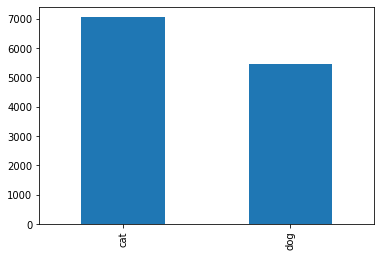

In [140]:
test_df['category'].value_counts().plot.bar()

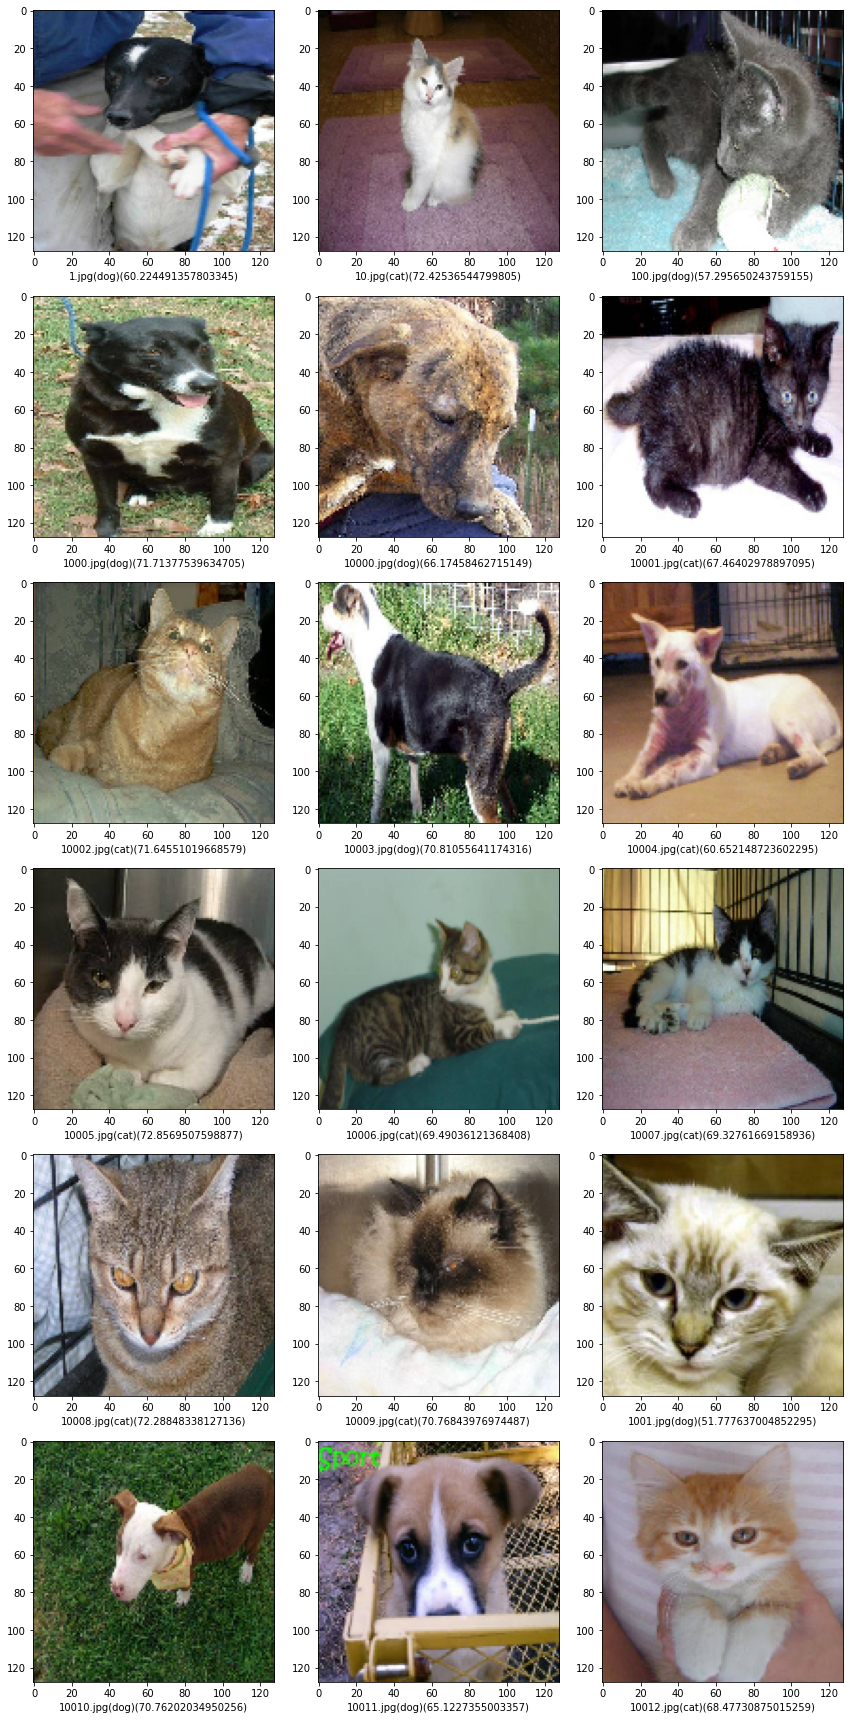

In [141]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = tf.keras.preprocessing.image.load_img(DATA_DIR + "/test/"+filename, target_size=IMAGE_SHAPE)
    score = tf.nn.softmax(predict[index])
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + "({})".format(category) + "({})".format(100 * np.max(score)) )
plt.tight_layout()
plt.show()

### See predicted

In [117]:
internet_dir = DATA_DIR + "/internet/"
internet_filenames = os.listdir(internet_dir)
internet_df = pd.DataFrame({
    'filename': internet_filenames
})
nbinternet_samples = internet_df.shape[0]

In [118]:
internet_gen = tfi.ImageDataGenerator(rescale=1./255)
internet_generator = internet_gen.flow_from_dataframe(
    internet_df, 
    internet_dir, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SHAPE,
    batch_size=3,
    shuffle=False
)

Found 6 validated image filenames.


In [121]:
predict = model.predict_generator(internet_generator)
internet_df['category'] = np.argmax(predict, axis=-1)

<ipython-input-121-1dd3571f2c14>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(internet_generator)


In [125]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
internet_df['category'] = internet_df['category'].replace(label_map)

In [126]:
internet_df['category'] = internet_df['category'].replace({0: 'cat', 1: 'dog'})

<AxesSubplot:>

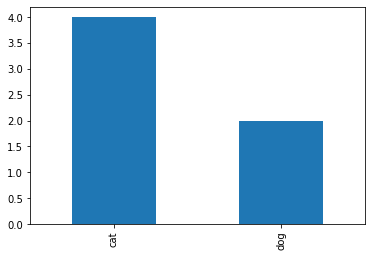

In [127]:
internet_df['category'].value_counts().plot.bar()

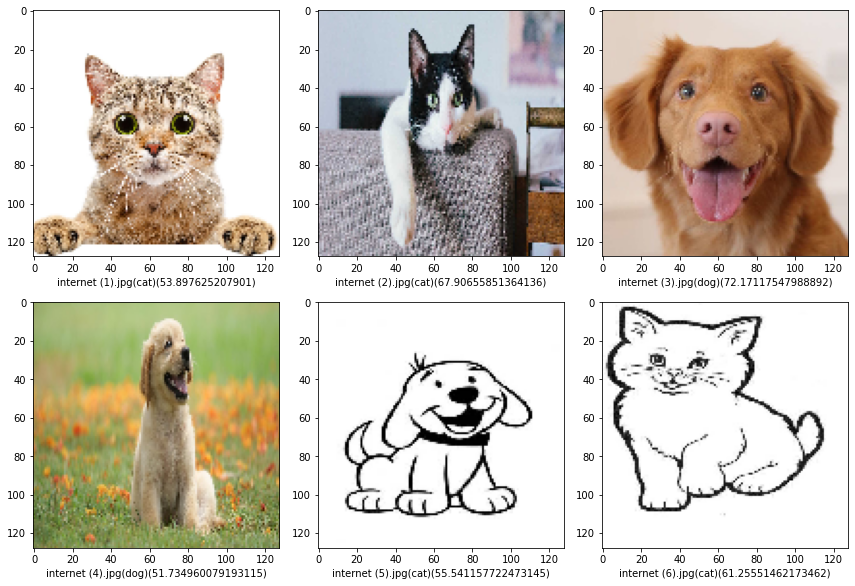

In [133]:
sample_test = internet_df.head(6)
sample_test.head()
plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = tf.keras.preprocessing.image.load_img(internet_dir+filename, target_size=IMAGE_SHAPE)
    score = tf.nn.softmax(predict[index])
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + "({})".format(category) + "({})".format(100 * np.max(score)) )

plt.tight_layout()
plt.show()